# Basic usage

Create an instance of PyFBU

In [1]:
import fbu
myfbu = fbu.PyFBU()

Supply the input distribution to be unfolded as a 1-dimensional list for N bins, with each entry corresponding to the bin content.

In [2]:
myfbu.data = [100,150]

Supply the response matrix where each row corresponds to a truth level bin.
The normalization of each row must be the acceptance efficiency of the corresponding bin (e.g. the normalization is 1 for resolution only unfolding).
N.B. For now, only squared response matrices are allowed.

In [3]:
myfbu.response = [[0.08,0.02], #first truth bin
                  [0.02,0.08]] #second truth bin

Define the boundaries of the hyperbox to be sampled for each bin.

In [4]:
myfbu.lower = [0,0]
myfbu.upper = [3000,3000]

Run the MCMC sampling (this step might take up to several minutes for a large number of bins).

In [5]:
myfbu.run()

Assigned Metropolis to truth0
Assigned Metropolis to truth1
100%|██████████| 11000/11000 [00:04<00:00, 2474.39it/s]


Retrieve the N-dimensional posterior distribution in the form of a list of N arrays.

In [6]:
trace = myfbu.trace
print( trace )

[array([800, 800, 750, ..., 871, 871, 871]), array([1529, 1592, 1592, ..., 1639, 1639, 1639])]


Each array corresponds to the projection of the posterior distribution for a given bin.

Text(0,0.5,'probability')

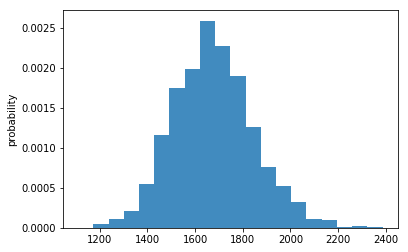

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.hist(trace[1],
         bins=20,alpha=0.85,
         normed=True)
plt.ylabel('probability')

# Background

One or more backgrounds, with the corresponding normalization uncertainties (gaussian prior), can be taken into account in the unfolding procedure.

In [8]:
myfbu.background = {'bckg1':[20,30],'bckg2':[10,10]}
myfbu.backgroundsyst = {'bckg1':0.5,'bckg2':0.04} #50% normalization uncertainty for bckg1 and 4% normalization uncertainty for bckg2

The background normalization is sampled from a gaussian with the given uncertainty. To fix the background normalization the uncertainty should be set to 0.

# Systematics

Systematic uncertainties affecting signal and background can be taken into account as well with their per-bin relative magnitudes. The prior is gaussian. Each systematics needs to be provided for each background listed at the previous step. 

In [9]:
myfbu.objsyst = {
    'signal':{'syst1':[0.,0.03],'syst2':[0.,0.01]},
    'background':{
            'syst1':{'bckg1':[0.,0.],'bckg2':[0.1,0.1]},
            'syst2':{'bckg1':[0.,0.01],'bckg2':[0.,0.]}
    }
}

Each systematics is treated as fully correlated across signal and the various backgrounds.

# Nuisance parameters

The posterior probability for the nuisance parameters is stored in a dictionary of arrays. The correlation among nuisance parameters and with the estimates for the unfolded distribution is preserved in the array ordering.

In [10]:
myfbu.run() #rerun sampling with backgrounds and systematics

Assigned Metropolis to truth0
Assigned Metropolis to truth1
Assigned NUTS to gaus_bckg1_lowerbound__
Assigned NUTS to gaus_bckg2_lowerbound__
Assigned NUTS to gaus_syst1
Assigned NUTS to gaus_syst2
100%|█████████▉| 10993/11000 [00:31<00:00, 351.04it/s]/Users/francesco/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 26 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 11000/11000 [00:31<00:00, 350.99it/s]


In [11]:
unfolded_bin1 = myfbu.trace[1]
bckg1 = myfbu.nuisancestrace['bckg1']

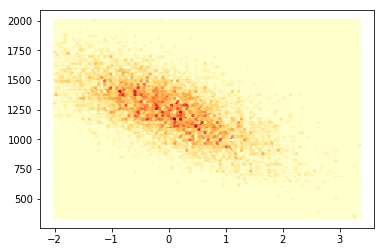

In [12]:
plt.hexbin(bckg1,unfolded_bin1,cmap=plt.cm.YlOrRd)

# Regularization

The Regularization class allows to impose an additional prior on the unfolded parameters to estimate in the form of $e^{-\alpha·S(T)}$, where S(T) is a regularization function.

In [13]:
from fbu import Regularization
myfbu.regularization = Regularization('Tikhonov',parameters=[{'refcurv':0.,'alpha':0.1}])

## Tikhonov

A Tikhonov regularization is implemented in the Regularization class. The regularization function is $S(T)=|C(T)-C(T')|$, with $C(T)=\Sigma_{i=2}^N(t_{i-1}-2·t_{i}+t_{i+1})^2$. The regularization strength $\alpha$ and the reference curvature C(T') need to be provided in the parameters dictionaries. The regularization can be applied to sub-ranges of bins (e.g. for multi-dimensional unfolding) and the number of dictionaries defines the number of differential bins.

In [14]:
myfbu.regularization = Regularization('Tikhonov',parameters=[{'refcurv':0.,'alpha':0.1},{'refcurv':0.2,'alpha':0.1}])